In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import keras

In [7]:
#Dataset load
ds_train = pd.read_csv("/clear_dataset.zip" , compression="zip")

In [8]:
ds_train.head()

,passenger_count,trip_duration,month_pickup,dow_pickup,hour_pickup,BoroCode,BoroName,dist_km,average_speed
0,1,455,3,0,17,1,Manhattan,1.498521,11.856428
1,1,663,6,6,0,1,Manhattan,1.805507,9.803659
2,1,2124,1,1,11,1,Manhattan,6.385098,10.822201
3,1,429,4,2,19,1,Manhattan,1.485498,12.465721
4,1,435,3,5,13,1,Manhattan,1.188588,9.836594


### One hot encoding categorical features

In [9]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('int64')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
ds_train = oneHotEncode(ds_train, ["BoroCode"])

### Circular predictors for hours, month and day_of_week variables

In [10]:
ds_train['sin_hour_pickup'] = np.sin(2*np.pi*ds_train.hour_pickup/24)
ds_train['cos__hour_pickup'] = np.cos(2*np.pi*ds_train.hour_pickup/24)
ds_train.drop('hour_pickup', axis=1, inplace=True)

In [11]:
ds_train['sin_month_pickup'] = np.sin(2*np.pi*ds_train.month_pickup/12)
ds_train['cos__month_pickup'] = np.cos(2*np.pi*ds_train.month_pickup/12)
ds_train.drop('month_pickup', axis=1, inplace=True)

In [12]:
ds_train['sin_dow_pickup'] = np.sin(2*np.pi*ds_train.dow_pickup/7)
ds_train['cos__dow_pickup'] = np.cos(2*np.pi*ds_train.dow_pickup/7)
ds_train.drop('dow_pickup', axis=1, inplace=True)

### Feature selection


Removal average speed since it is calculated based on the predicted variable

In [13]:
ds_train.drop(['average_speed', "BoroName"], axis=1, inplace=True)

### Y and X variables


In [14]:
y_values = ds_train["trip_duration"]
x_values = ds_train.drop(["trip_duration"],axis=1)

## Random forest model as benchmark

In [43]:
train_X, val_X, train_y, val_y = train_test_split(x_values, y_values, test_size = 0.25, random_state = 12)

from sklearn.model_selection import RandomizedSearchCV
random_grid = {'max_depth': [5, 10, 12, 14]}
random_forest = RandomForestRegressor()
random_forest_grid = RandomizedSearchCV(estimator = random_forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

random_forest_grid.fit(train_X, train_y)

predicted_trip_duration = random_forest_grid.predict(val_X)
MSLE = 	mean_squared_log_error(val_y , predicted_trip_duration)
print('Random forest validation MSLE = ', MSLE)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Random forest validation MSLE =  0.18749680681619824


In [44]:
random_forest_grid.best_estimator_

RandomForestRegressor(max_depth=12)

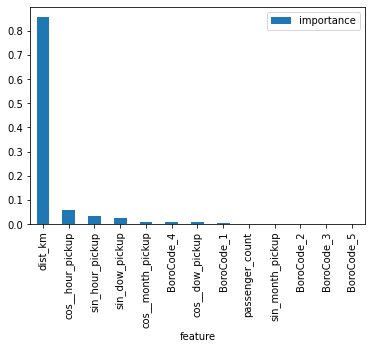

In [45]:
importances = pd.DataFrame({'feature':train_X.columns,'importance':np.round(random_forest_grid.best_estimator_.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()

# Train vanilla neural network

In [15]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = ds_train.shape[1]-1, activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer='adam', metrics=keras.losses.MeanSquaredLogarithmicError())
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1792      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 166,657
Trainable params: 166,657
Non-trainable params: 0
_________________________________________________________________


In [16]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
NN_model.fit(x_values, y_values, epochs=50, batch_size=1024, validation_split = 0.25, callbacks=callbacks_list)


In [32]:
NN_model.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_4')>